## Recommendation system using Word2Vec model

Word2Vec algorithm showed that we can use a vector (a list of numbers) to properly represent words in a way that captures semantic or meaning-related relationships (e.g. the ability to tell if words are similar, or opposites, or that a pair of words like “Stockholm” and “Sweden” have the same relationship between them as “Cairo” and “Egypt” have between them) as well as syntactic, or grammar-based, relationships (e.g. the relationship between “had” and “has” is the same as that between “was” and “is”). (Source: aman.ai)


Word2Vec is generally used in NLP to create embeddings. Embeddings are mathematical values that are used to represent words (and their context). We can assume that similar words will have nearly same embedding values (eg. man and woman).

Recommendation problem can be solved with Word2Vec model. Refer these links:
1. https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484
2. https://medium.com/airbnb-engineering/listing-embeddings-for-similar-listing-recommendations-and-real-time-personalization-in-search-601172f7603e
3. https://arxiv.org/pdf/1606.07154.pdf
4. https://arxiv.org/pdf/1607.01869.pdf

We can draw comparison between the sequence of operations performed by the user and the sentences in text. This will help us to get the embeddings for the individual entities the user accessed in the sequence and get embeddings for it. Once we have the mathematical values we can use them for different types of tasks like finding similar items, not similar items, top k closest items, etc.

#### Followed the code presented in https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

#### Importing libraries

In [28]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

#### Loading the dataset

In [2]:
data = pd.read_csv("./../data/online_retail.csv")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 8:26,3.39,17850.0,United Kingdom


In [8]:
data.shape

(541909, 8)

### Description of the dataset

1. **InvoiceNo:** Invoice number. a unique number assigned to each transaction
2. **StockCode:** Product/item code. a unique number assigned to each distinct product
3. **Description:** Product description
4. **Quantity:** The quantities of each product per transaction
5. **InvoiceDate:** Invoice Date and time. The day and time when each transaction was generated
6. **CustomerID:** Customer number. a unique number assigned to each customer

#### Data preprocessing

In [10]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
data.dropna(inplace=True)

In [12]:
data.shape

(406829, 8)

In [13]:
data['StockCode'] = data['StockCode'].astype(str)

#### Dividing data in testing and training dataset

In [15]:
customerIDs = data.CustomerID.unique().tolist()

In [16]:
random.shuffle(customerIDs)

In [17]:
customerIDs_train = [customerIDs[i] for i in range(round(0.9*len(customerIDs)))]

In [19]:
data_train = data[data['CustomerID'].isin(customerIDs_train)]
data_test = data[-data['CustomerID'].isin(customerIDs_train)]

In [24]:
purchase_sequence_train = []

for i in tqdm(customerIDs_train):
    purchase_sequence_individual = data_train[data_train['CustomerID']==i]['StockCode'].tolist()
    purchase_sequence_train.append(purchase_sequence_individual)

100%|█████████████████████████████████████| 3935/3935 [00:02<00:00, 1646.78it/s]


In [25]:
purchase_sequence_test = []

for i in tqdm(data_test.CustomerID.unique()):
    purchase_sequence_individual = data_test[data_test['CustomerID']==i]['StockCode'].tolist()
    purchase_sequence_test.append(purchase_sequence_individual)

100%|███████████████████████████████████████| 437/437 [00:00<00:00, 2441.38it/s]


#### Creating Word2Vec model to get the embeddings

1. **window:** This dictates the number of words to be considered on the left and right of the main word.
2. **sg:** This is the skip-gram parameter. If this is set as 1 then it means skip-gram algorithm will be used (predicts the target word using the context words). If this is 0, then the function use CBOW (continuous bag of words) will be used (predicts the context words using the target word).
3. **hs:** Hierarchichal softmax, if its 0 then negative sampling is being used which is more memory efficient. If its 1 then negative samling is not used.
4. **negative:** Dictates the number of negative samples to be used.
5. **alpha:** Learning rate
5. **min_alpha:** Minimum value alpha can take
6. **seed:** Used to reproduce the result, same seed values will give same result

In [29]:
model = Word2Vec(window=10, sg=1, hs=0, 
                negative=10, alpha=0.03,
                min_alpha=0.0007, seed=14)

This code builds the voacabulary using the data passed. It also assigns unique identifier to each word.

In [74]:
model.build_vocab(purchase_sequence_train, progress_per=10)

In [32]:
model.train(purchase_sequence_train, total_examples=model.corpus_count, epochs=10, report_delay=1)

(3690575, 3728010)

In [33]:
model.init_sims(replace=True)

/var/folders/wz/cnwy77v95fz65y4_p_vs2l140000gn/T/ipykernel_89408/1992334471.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [34]:
print(model)

Word2Vec<vocab=3171, vector_size=100, alpha=0.03>


In [36]:
X = model.wv.vectors
vocab = model.wv.index_to_key
X.shape

(3171, 100)

In [52]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

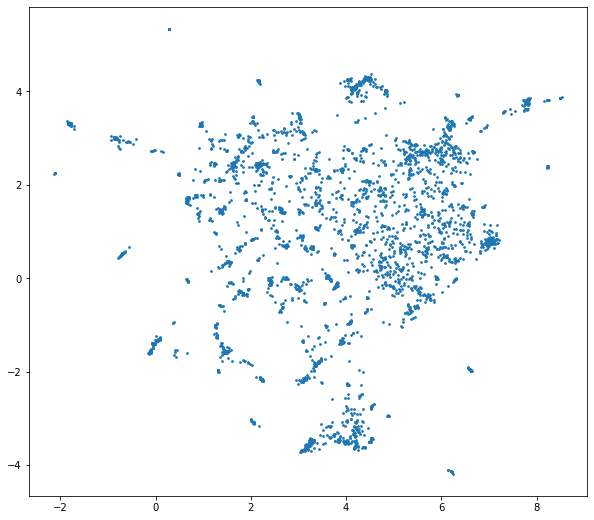

In [53]:
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [54]:
products = data_train[["StockCode", "Description"]]

In [56]:
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

/var/folders/wz/cnwy77v95fz65y4_p_vs2l140000gn/T/ipykernel_89408/2105348338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.drop_duplicates(inplace=True, subset='StockCode', keep="last")


In [79]:
def similar_products(v, n = 6):
    # extract most similar products for the input vector
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms

In [80]:
print("The product 90019A is:", (products_dict['90019A']))
similar_products(model.wv['90019A'])

The product 90019A is: ['SILVER M.O.P ORBIT BRACELET']


[('FOLDING UMBRELLA BLACKBLUE POLKADOT', 0.8222659826278687),
 ('SET/3 RABBITS FLOWER SKIPPPING ROPE', 0.8187665939331055),
 ('WOODLAND LARGE RED FELT HEART', 0.7946421504020691),
 ('WRAP CHRISTMAS SCREEN PRINT', 0.7869718074798584),
 ('SET OF 2 CERAMIC PAINTED HEARTS ', 0.7619646191596985),
 ('WHITE CANDYSTUFT ARTIFICIAL FLOWER', 0.7550341486930847)]

In [69]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
    return np.mean(product_vec, axis=0)

In [70]:
len(purchase_sequence_test[0])

67

In [71]:
aggregate_vectors(purchase_sequence_test[0]).shape

(100,)

In [72]:
similar_products(aggregate_vectors(purchase_sequence_test[0]))

[('ALARM CLOCK BAKELIKE GREEN', 0.7690986394882202),
 ('ALARM CLOCK BAKELIKE IVORY', 0.7690050601959229),
 ('ALARM CLOCK BAKELIKE PINK', 0.764397144317627),
 ('ALARM CLOCK BAKELIKE ORANGE', 0.7529542446136475),
 ('ALARM CLOCK BAKELIKE CHOCOLATE', 0.7283250093460083),
 ('BLUE DINER WALL CLOCK', 0.6657717823982239)]

In [73]:
similar_products(aggregate_vectors(purchase_sequence_test[0][-10:]))

[('ALARM CLOCK BAKELIKE CHOCOLATE', 0.7450459599494934),
 ('ALARM CLOCK BAKELIKE RED ', 0.7450198531150818),
 ('ALARM CLOCK BAKELIKE IVORY', 0.7437461614608765),
 ('ALARM CLOCK BAKELIKE PINK', 0.730961799621582),
 ('ALARM CLOCK BAKELIKE ORANGE', 0.6724289655685425),
 ('BLUE DINER WALL CLOCK', 0.5965649485588074)]